In [3]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

In [4]:
import sys

sys.path.append("../src")

from deep_learning_models import *

from deep_learning_functions import *



In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


Matplotlib created a temporary config/cache directory at /var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/matplotlib-c9rgaq3w because the default path (/Users/ibemmene/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [6]:
from tensorflow.keras import Input, regularizers, Model
from tensorflow.keras.layers import Bidirectional, Dropout, LSTM, Dense, Concatenate
from tensorflow.keras.metrics import Precision, Recall

from sklearn.model_selection import train_test_split

In [7]:
SEED = 23
data_dir = Path("../Daten/data_to_use")

In [48]:
def load_prepare_data(name, cutoff = None):
    
    datanames = [ "brazil_gaz", "japan", "brazil", "ticino", "US"]
    static_features = ["nbids", "cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks"]
    
    if name not in datanames + ["all"]:
        print("This is not a dataset ")
    
    if name == "all":
        data = []
        
        for ds in tqdm(datanames):
            df = pd.read_json(data_dir/f"{ds}_train.json")
            if "ID" in df.keys():
                df.rename(columns = {"ID": "project"}, inplace = True)
            if "Price" in df.keys():
                df.rename(columns = {"Price": "bid"}, inplace = True)
            if "complete" in df.keys(): #complete/incomplete is just a case in Swiss dataset, take care of it later
                df.rename(columns = {"complete": "cartel"}, inplace = True)
                
            df["project"] = df.project.apply(lambda s: f"{ds}/{s}" )
            
            data.append(df[static_features + ["bid", "project", "cartel"]])
            
            
        df = pd.concat(data)
        
       
    else:
        df = pd.read_json(data_dir/f"{name}_train.json")
    #print(df.head())
    if name == "brazil_gaz":
        df.rename(columns = {"Price": "bid", "ID": "project"}, inplace = True)
        
    if cutoff != None:
        df = df[df.nbids<=cutoff]
        
    
    df.dropna(inplace = True)
    
    df_grouped = df.groupby(by="project").head(1).reset_index()
    df_grouped.drop(columns=["bid"], inplace = True)
    df_grouped = df_grouped.merge(df.groupby(by="project")["bid"].apply(list), left_on = "project", right_on = "project")

    df_grouped["bid"] = df_grouped.bid.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
    df_grouped["bid"] = df_grouped.bid.apply(lambda x: np.sort(x)[::-1])

    padding_length = max(np.asarray(df_grouped.nbids.tolist()))
    df_grouped["bid"] = df_grouped.bid.apply(lambda x: np.pad(x, (0,padding_length-len(x))))

    df_grouped.dropna(subset = ["bid"], inplace = True)

    df_train, df_test = train_test_split(df_grouped, test_size = 0.2, stratify = df_grouped.cartel, random_state = SEED)
    
    X_static_train = np.asarray(df_train[static_features]).astype('float32')
    X_static_test = np.asarray(df_test[static_features]).astype('float32')
    
    X = np.array(df_train.bid.tolist())
    X_train = X.reshape(X.shape[0], X.shape[1], 1)

    X_test = np.array(df_test.bid.tolist())
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    y_train = df_train.cartel
    y_test = df_test.cartel
    
       
    
    return X_static_train, X_static_test, X_train, X_test, y_train, y_test

In [7]:
X_static_train, X_static_test, X_recurrent_train, X_recurrent_test, y_train, y_test = load_prepare_data("all", cutoff = 100)

  0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
checkpoint_filepath = Path("../checkpoints/training1")

In [28]:
test_model = BiLSTM_LSTMModel()

test_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only= True,
    monitor='val_precision_11',
    mode='max',
    save_best_only=True)

hist_test = test_model.fit(X_recurrent_train,
                 y_train,
                 epochs =3, 
                 batch_size = 64,
                 validation_data = (X_recurrent_test,y_test),
                 callbacks=[model_checkpoint_callback])

2022-08-21 23:56:54.794363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 23:56:55.205984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 23:56:55.222150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 23:56:55.653648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 23:56:55.999734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 23:56:56.297448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 23:56:56.313628: I tensorflow/core/grappler/optimizers/cust

37/37 [==============================] - ETA: 0s - loss: 4.1300 - precision_11: 0.4561 - recall_11: 0.0483

2022-08-21 23:57:00.383035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 23:57:00.536091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 23:57:00.543519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 23:57:00.763457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 10s 144ms/step - loss: 4.1300 - precision_11: 0.4561 - recall_11: 0.0483 - val_loss: 2.3602 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00


In [ ]:
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [31]:
from tensorflow_addons.metrics import F1Score

ModuleNotFoundError: No module named 'tensorflow.compiler.tf2mlcompute'

In [29]:
import tensorflow_addons as tfa

/opt/homebrew/Caskroom/miniforge/base/envs/eventfrog/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


ModuleNotFoundError: No module named 'tensorflow.compiler.tf2mlcompute'

In [36]:
from tensorflow.python.compiler.mlcompute import mlcompute

ModuleNotFoundError: No module named 'tensorflow.python.compiler.mlcompute'

In [32]:
from sklearn.metrics import f1_score

In [ ]:
sklearn.metrics.f1_score

In [ ]:
def f1_metric(x,y):
    

In [35]:
for i in range(10):
    test_model = BiLSTM_LSTMModel()

    test_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])
    checkpoint_filepath = Path(f"../checkpoints/training{i}")
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only= True,
        monitor=f'val_precision_{11+i}',
        mode='max',
        save_best_only=True)

    hist_test = test_model.fit(X_recurrent_train,
                y_train,
                epochs =1, 
                batch_size = 64,
                validation_data = (X_recurrent_test,y_test),
                callbacks=[model_checkpoint_callback])

NameError: name 'sklearn' is not defined

In [39]:
hist_test.history["precision_11"]

[0.45614033937454224]

In [22]:
def my_f1(precision, recall):
    
    return 2*(precision*recall)/(precision+recall)

In [41]:
my_f1(np.asarray(hist_test.history["precision_11"]), np.asarray(hist_test.history["recall_11"]))

array([0.08739496])

In [42]:
hist_test.history.keys()

dict_keys(['loss', 'precision_11', 'recall_11', 'val_loss', 'val_precision_11', 'val_recall_11'])

# Look at first five randomizations data

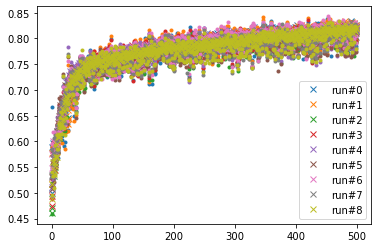

In [26]:
best_f1_val = []
best_f1 = []

average_f1 = []
average_f1_val = []

for i in range(9):
    if i == 0:
        precision = np.load(Path(f"../results/randomness/all_precision_{i}.npy"))
        recall = np.load(f"../results/randomness/all_recall_{i}.npy")
        
        precision_val = np.load(Path(f"../results/randomness/all_val_precision_{i}.npy"))
        recall_val = np.load(f"../results/randomness/all_val_recall_{i}.npy")
        loss_val = np.load(f"../results/randomness/all_val_loss_{i}.npy")
        
    else:
        precision = np.load(Path(f"../results/randomness/all_precision_{i}_{i}.npy"))
        recall = np.load(f"../results/randomness/all_recall_{i}_{i}.npy")
        
        precision_val = np.load(Path(f"../results/randomness/all_val_precision_{i}_{i}.npy"))
        recall_val = np.load(f"../results/randomness/all_val_recall_{i}_{i}.npy")
        loss_val = np.load(f"../results/randomness/all_val_loss_{i}.npy")
        
    f1 = my_f1(precision, recall)
    f1_val = my_f1(precision_val, recall)
    best_f1.append(f1[loss_val == min(loss_val)])
    best_f1_val.append(f1_val[loss_val == min(loss_val)])
    
    average_f1.append(np.mean(f1[-10::]))
    average_f1_val.append(np.mean(f1_val[-10::]))
    
    plt.plot(f1, "x", label = f"run#{i}", color = f"C{i}")
    plt.plot(f1_val,".", color = f"C{i}")
    
plt.legend()

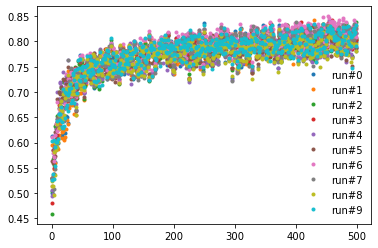

In [21]:
best_f1_val = []
best_f1 = []

average_f1 = []
average_f1_val = []

for i in range(10):
    if i == 0:
        precision = np.load(Path(f"../results/randomness/all_precision_{i}.npy"))
        recall = np.load(f"../results/randomness/all_recall_{i}.npy")
        
        precision_val = np.load(Path(f"../results/randomness/all_val_precision_{i}.npy"))
        recall_val = np.load(f"../results/randomness/all_val_recall_{i}.npy")
        loss_val = np.load(f"../results/randomness/all_val_loss_{i}.npy")
        
    else:
        precision = np.load(Path(f"../results/randomness/all_precision_{i}_{i}.npy"))
        recall = np.load(f"../results/randomness/all_recall_{i}_{i}.npy")
        
        precision_val = np.load(Path(f"../results/randomness/all_val_precision_{i}_{i}.npy"))
        recall_val = np.load(f"../results/randomness/all_val_recall_{i}_{i}.npy")
        loss_val = np.load(f"../results/randomness/all_val_loss_{i}.npy")
        
    f1 = my_f1(precision, recall)
    f1_val = my_f1(precision_val, recall)
    best_f1.append(f1[loss_val == min(loss_val)][0])
    best_f1_val.append(f1_val[loss_val == min(loss_val)][0])
    
    average_f1.append(np.mean(f1[-10::]))
    average_f1_val.append(np.mean(f1_val[-10::]))
    
    #plt.plot(f1, "x", label = f"run#{i}", color = f"C{i}")
    plt.plot(f1_val,".", label = f"run#{i}", color = f"C{i}")
    
plt.legend(frameon = False)

In [24]:
result = pd.DataFrame({"best_f1_val": best_f1_val, "best_f1_": best_f1})

best_f1_val  best_f1_
0     0.798097  0.817778
1     0.810912  0.811312
2     0.821743  0.820742
3     0.808500  0.818547
4     0.817274  0.819064
5     0.804414  0.813453
6     0.824640  0.831421
7     0.828155  0.821622
8     0.801724  0.801971
9     0.832664  0.817337

In [30]:
print(result.style.to_latex())

\begin{tabular}{lrr}
 & best_f1_val & best_f1_ \\
0 & 0.798097 & 0.817778 \\
1 & 0.810912 & 0.811312 \\
2 & 0.821743 & 0.820742 \\
3 & 0.808500 & 0.818547 \\
4 & 0.817274 & 0.819064 \\
5 & 0.804414 & 0.813453 \\
6 & 0.824640 & 0.831421 \\
7 & 0.828155 & 0.821622 \\
8 & 0.801724 & 0.801971 \\
9 & 0.832664 & 0.817337 \\
\end{tabular}



In [31]:
print(best_f1_val)
print("mean: ",np.mean(best_f1_val))
print("std: ",np.std(best_f1_val))

print(best_f1)
print("mean: ",np.mean(best_f1))
print("std: ",np.std(best_f1))

[0.7980974884354215, 0.8109122218667408, 0.82174299869073, 0.8084997485703713, 0.8172743219115998, 0.804413974279161, 0.8246400261706762, 0.8281550167528887, 0.801723647416763, 0.8326636530381607]
mean:  0.8148123097132514
std:  0.011230588045327545
[0.8177777957955114, 0.8113124232697811, 0.8207420699465503, 0.8185466035430377, 0.8190644342244093, 0.8134528971395824, 0.8314209999507399, 0.8216216390402215, 0.8019713113489, 0.8173374665575432]
mean:  0.8173247640816277
std:  0.0072141377093488945


In [61]:
print(average_f1_val)
print("mean: ",np.mean(average_f1_val))
print("std: ",np.std(average_f1_val))

print(average_f1)
print("mean: ",np.mean(average_f1))
print("std: ",np.std(average_f1))

[0.8032705134397364, 0.8034688649716959, 0.7964548003954547, 0.8067375342382661, 0.7952133879628759, 0.7859797988691284, 0.8095134851416754, 0.8012868356941659, 0.800011722247676]
mean:  0.8002152158845194
std:  0.006598951153247098
[0.8251416131456668, 0.8244095124349515, 0.8127818471413771, 0.8221090060333033, 0.8150022030652291, 0.8120101953678723, 0.8233487678500111, 0.8199889082696575, 0.8182179479670477]
mean:  0.8192233334750129
std:  0.004716469437831596


**TODO:**
- redo when all the 10 randomizations are calculated
- move to official evaluation file

# K-Fold crossvalidation of all the models

In [7]:
from sklearn.model_selection import StratifiedKFold

In [8]:
X_static, X_recurrent, y = load_prepare_data_eval("all")

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 23)

In [10]:
skf.split(X_static_train, y_train)

NameError: name 'X_static_train' is not defined

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 23)
skf.split(X_static_train, y_train)

In [11]:
for train_index, test_index in skf.split(X_static, y):
    print(y[test_index])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0
 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 1 0 0 1 0 0 

In [55]:
y[train_index]

array([1, 1, 1, ..., 0, 0, 0])

In [132]:
import os

In [30]:
test_index

array([   1,    5,    7,   25,   27,   28,   32,   39,   40,   44,   47,
         49,   55,   65,   66,   71,   74,   79,   80,   89,   93,   97,
         99,  101,  106,  107,  123,  126,  134,  136,  140,  146,  154,
        158,  161,  187,  191,  196,  198,  206,  209,  210,  213,  238,
        247,  249,  257,  259,  269,  271,  283,  287,  291,  292,  293,
        295,  314,  317,  321,  330,  333,  336,  343,  351,  374,  376,
        377,  380,  381,  393,  400,  409,  410,  416,  419,  420,  421,
        431,  436,  437,  448,  450,  462,  488,  495,  496,  497,  498,
        517,  521,  522,  526,  530,  532,  538,  540,  541,  542,  543,
        547,  557,  563,  567,  577,  578,  590,  594,  597,  600,  602,
        606,  607,  609,  610,  616,  617,  625,  629,  634,  638,  646,
        661,  664,  666,  677,  684,  691,  695,  696,  697,  699,  706,
        709,  711,  720,  727,  729,  733,  739,  744,  746,  747,  757,
        758,  759,  764,  770,  781,  785,  791,  7

In [29]:
shuffle(train_index)
shuffle(test_index)

array([2446, 1892,  610, 2225, 1241, 1257,  999, 3005, 2307, 1287, 2646,
       1075,  291, 1100, 2720,  813,   39, 2380, 1972, 1636,  677, 2820,
       2679, 1184, 2496, 2128, 2208, 2795, 1900, 1712, 1846, 2701, 3043,
        521, 1558,  843, 1199,  880, 2905, 2908,  634, 1217,   32,  954,
       2874, 1767, 2233, 1282, 2163,  351,  146,   27,  498, 2604, 2601,
       1179, 1222, 2405, 1801, 2815, 1932, 1160, 1180, 1137, 1315,   74,
       1081, 1028, 2628, 1669,  597, 1519,  957, 2805,  870, 2627,  450,
       2486,  158, 2784, 2146, 2406, 2953, 3074, 1822,  530,  126,  759,
        134, 1272, 1488,  416,  791,   66, 1690, 2964, 1521, 1277, 2974,
       2013,  522,  796, 2969, 2044, 1883, 1901, 3108, 1448, 2962, 1653,
        198,  540, 1936,  295, 1576,  343, 2171, 1888, 2081, 2348, 1026,
       2318, 2556, 2136,  764, 1012, 2212,  293,   79,   55,  196,  805,
        709, 2504, 2712, 2035,  920,  727, 2449, 1388,  448,  902, 2686,
       1818, 1758, 2372, 1790,  785,   99, 1402, 19

In [32]:
y[shuffle(test_index)]

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,

In [35]:
test_index = shuffle(test_index)

In [39]:
y[shuffle(train_index)]

array([1, 0, 0, ..., 1, 1, 1])

In [40]:
train_index = shuffle(train_index)

In [36]:
y[test_index]

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,

In [12]:
from sklearn.utils import shuffle

In [13]:
from sklearn.preprocessing import StandardScaler

In [19]:
for i in range(len(y[train_index])):
    print(y[train_index][i])

0
0
0
1
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
1
0
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
0
1
0
0
1
1
1
1
0
0
1
0
1
1
0
0
0
1
1
0
0
0
1
0
0
0
1
1
0
0
0
0
0
1
1
1
1
0
1
1
0
0
1
0
0
1
0
0
1
0
1
0
0
0
0
1
0
0
1
0
1
0
0
0
1
1
0
1
1
0
1
0
0
0
1
1
1
0
0
0
1
1
0
0
1
1
1
0
1
0
0
1
0
1
1
1
0
0
0
1
0
1
1
1
0
0
0
0
1
0
1
0
0
0
0
1
1
0
1
0
1
0
1
1
0
1
0
1
1
0
1
1
0
1
1
0
1
0
0
1
0
1
1
0
1
1
1
1
0
1
0
1
1
1
0
1
0
1
1
0
0
0
1
1
0
1
1
1
0
0
0
1
0
0
0
1
0
0
1
0
0
0
0
0
1
0
0
0
1
0
1
0
1
0
0
0
0
0
0
1
0
1
0
0
0
1
0
0
0
1
1
1
0
0
1
0
0
1
1
0
1
1
1
0
1
0
1
0
0
1
1
0
0
1
1
1
1
1
0
1
1
1
0
0
1
0
0
1
0
1
1
1
1
1
1
1
0
1
0
0
1
0
0
0
1
0
0
0
0
0
1
0
0
0
0
1
0
1
0
1
0
1
0
1
1
1
1
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
0
0
0
1
1
0
0
0
0
0
1
1
0
1
0
0
0
1
1
0
0
0
1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
0
0
0
1
1
0
0
1
0
1
0
0
0
1
1
1
0
1
1
0
1
1
1
1
0
1
0
1
0
1
0
0
0
0
1
1
1
0
1
1
0
0
0
1
1
0
1
1
0
1
0
1
0
1
0
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
1
1
1
0
0
1
0
0
0
0
0
0
0
0
1
0
1
0
1
0
1
1


In [20]:
models = [
        ('BiLSTM_LSTM', BiLSTM_LSTMModel)
    ]

scaler = StandardScaler()

train_index = shuffle(train_index)
test_index = shuffle(test_index)

X_static_train = scaler.fit_transform(X_static[train_index])
X_static_test = scaler.transform(X_static[test_index])


for model_name, model_factory in models:
    model = model_factory()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])
    hist = model.fit(X_recurrent[train_index],
                         y[train_index],
                         epochs=2,
                         batch_size=128,
                         validation_data=(X_recurrent[test_index], y[test_index])
                         )

Epoch 1/2


2022-09-18 14:31:06.607234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 14:31:07.030809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 14:31:07.041711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 14:31:09.532611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 14:31:10.922037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 14:31:14.056597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 14:31:14.184827: I tensorflow/core/grappler/optimizers/cust

20/20 [==============================] - ETA: 0s - loss: 5.0630 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

2022-09-18 14:31:39.587513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 14:31:39.726642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 14:31:39.734389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-18 14:31:41.690138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 41s 1s/step - loss: 5.0630 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 3.7064 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/2
20/20 [==============================] - 16s 722ms/step - loss: 2.9199 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 2.1999 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00


In [24]:
from deep_learning_models import BiLSTM_LSTMModel

In [28]:
y[test_index]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [51]:
model = BiLSTM_LSTMModel_debug()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])
hist = model.fit(X_recurrent[train_index],
                         y[train_index],
                         epochs=3,
                         batch_size=64,
                         validation_data=(X_recurrent[test_index], y[test_index])
                         )

Epoch 1/3
Tensor("bi_lstm_lstm_model_debug_1/OUTPUT_LAYER/Sigmoid:0", shape=(None, 1), dtype=float32)
Tensor("bi_lstm_lstm_model_debug_1/OUTPUT_LAYER/Sigmoid:0", shape=(None, 1), dtype=float32)


2022-09-14 09:04:49.349474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-14 09:04:49.812381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-14 09:04:49.825519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-14 09:04:51.771979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-14 09:04:53.048636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-14 09:04:56.095399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-14 09:04:56.136042: I tensorflow/core/grappler/optimizers/cust

40/40 [==============================] - ETA: 0s - loss: 3.9899 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00Tensor("bi_lstm_lstm_model_debug_1/OUTPUT_LAYER/Sigmoid:0", shape=(None, 1), dtype=float32)


2022-09-14 09:05:24.562869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-14 09:05:24.707457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-14 09:05:24.717663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-14 09:05:26.538397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 45s 843ms/step - loss: 3.9899 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 2.1906 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/3
40/40 [==============================] - 21s 505ms/step - loss: 1.5133 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 1.0494 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/3
40/40 [==============================] - 19s 463ms/step - loss: 0.8856 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 0.7752 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00


In [26]:
class BiLSTM_LSTMModel_debug(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.n_outputs = 1
        self.rec_layer_one = Bidirectional(
            LSTM(128, kernel_regularizer=regularizers.L2(0.01),
                 recurrent_regularizer=regularizers.L2(0.01), return_sequences=True), name="BIDIRECTIONAL_LAYER_1")
        self.dropout_one = Dropout(0.1, name="DROPOUT_LAYER_1")

        self.rec_layer_two = LSTM(64, kernel_regularizer=regularizers.L2(0.01),
                                  recurrent_regularizer=regularizers.L2(0.01), name="LSTM_LAYER_1")
        self.dropout_two = Dropout(0.1, name="DROPOUT_LAYER_2")

        self.combined_dense_one = Dense(32, activation='relu', name="DENSE_LAYER_1")
        
        self.output_layer = Dense(self.n_outputs, activation='sigmoid', name="OUTPUT_LAYER")

    def call(self, inputs, return_embeddings=False):
        x = self.rec_layer_one(inputs)
        x = self.dropout_one(x)
        x = self.rec_layer_two(x)
        x = self.dropout_two(x)

        x = self.combined_dense_one(x)
        
        if return_embeddings:
            return x
        
        x = self.output_layer(x)
        print(x)

        return x

In [135]:
skf = StratifiedKFold(n_splits=5, shuffle = True)

i = 0
for train_index, test_index in skf.split(X_static, y):
    
    model = BiLSTM_LSTMDenseModel()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])
    
    checkpoint_filepath = Path(f"../checkpoints/training{i}/chp.ckpt")
    os.mkdir(checkpoint_filepath)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only= True,
        save_freq='epoch')
    
    hist = model.fit([X_recurrent[train_index], X_static[train_index]],
                         y[train_index],
                         epochs=1,
                         batch_size=64,
                         validation_data=([X_recurrent[test_index], X_static[test_index]], y[test_index]),
                         callbacks = [model_checkpoint_callback]
                         )
    print(hist.history.keys())
    i+=1
    
    

2022-09-01 15:03:56.318552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:03:57.175888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:03:57.186080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:03:59.938977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:04:01.981599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:04:05.610784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:04:05.823607: I tensorflow/core/grappler/optimizers/cust

40/40 [==============================] - ETA: 0s - loss: 4.2016 - precision_45: 0.5081 - recall_42: 0.5161

2022-09-01 15:04:40.118418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:04:40.482440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:04:40.494062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:04:43.682568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 57s 1s/step - loss: 4.2016 - precision_45: 0.5081 - recall_42: 0.5161 - val_loss: 2.1885 - val_precision_45: 0.6605 - val_recall_42: 0.3531
dict_keys(['loss', 'precision_45', 'recall_42', 'val_loss', 'val_precision_45', 'val_recall_42'])


2022-09-01 15:04:53.327950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:04:53.796833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:04:53.816422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:04:56.118465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:04:58.132379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:05:01.699746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:05:01.812833: I tensorflow/core/grappler/optimizers/cust

40/40 [==============================] - ETA: 0s - loss: 4.0456 - precision_46: 0.5379 - recall_43: 0.5681

2022-09-01 15:05:45.766538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:05:46.301000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:05:46.313916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:05:49.488401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 67s 1s/step - loss: 4.0456 - precision_46: 0.5379 - recall_43: 0.5681 - val_loss: 2.2298 - val_precision_46: 0.5311 - val_recall_43: 0.8449
dict_keys(['loss', 'precision_46', 'recall_43', 'val_loss', 'val_precision_46', 'val_recall_43'])


2022-09-01 15:06:00.858158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:06:01.482443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:06:01.509630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:06:04.791403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:06:06.576082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:06:10.179800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:06:10.280876: I tensorflow/core/grappler/optimizers/cust

40/40 [==============================] - ETA: 0s - loss: 4.0301 - precision_47: 0.5104 - recall_44: 0.5054

2022-09-01 15:06:45.378327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:06:45.655439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:06:45.678503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:06:47.873395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 56s 1s/step - loss: 4.0301 - precision_47: 0.5104 - recall_44: 0.5054 - val_loss: 2.1676 - val_precision_47: 0.5705 - val_recall_44: 0.5743
dict_keys(['loss', 'precision_47', 'recall_44', 'val_loss', 'val_precision_47', 'val_recall_44'])


2022-09-01 15:06:56.625525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:06:57.421129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:06:57.432115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:06:59.723367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:07:01.343218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:07:05.052551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:07:05.194908: I tensorflow/core/grappler/optimizers/cust

40/40 [==============================] - ETA: 0s - loss: 4.3017 - precision_48: 0.5112 - recall_45: 0.5665

2022-09-01 15:07:41.514746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:07:41.899967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:07:41.907201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-01 15:07:43.924464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 56s 1s/step - loss: 4.3017 - precision_48: 0.5112 - recall_45: 0.5665 - val_loss: 2.1757 - val_precision_48: 0.5438 - val_recall_45: 0.4917
dict_keys(['loss', 'precision_48', 'recall_45', 'val_loss', 'val_precision_48', 'val_recall_45'])


FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints/training4/chp.ckpt'

In [128]:
skf.get_n_splits(X_static)

5

In [ ]:
tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
    **kwargs
)

In [6]:
def load_prepare_data_eval(name, cutoff = None):
    
    datanames = [ "brazil_gaz", "japan", "brazil", "ticino", "US"]
    static_features = ["nbids", "cv", "spread", "diffp", "rd", "rdnorm", "rdalt", "skew", "ks"]
    
    if name not in datanames + ["all"]:
        print("This is not a dataset ")
    
    if name == "all":
        data = []
        
        for ds in tqdm(datanames):
            df = pd.read_json(data_dir/f"{ds}_train.json")
            if "ID" in df.keys():
                df.rename(columns = {"ID": "project"}, inplace = True)
            if "Price" in df.keys():
                df.rename(columns = {"Price": "bid"}, inplace = True)
            if "complete" in df.keys(): #complete/incomplete is just a case in Swiss dataset, take care of it later
                df.rename(columns = {"complete": "cartel"}, inplace = True)
                
            df["project"] = df.project.apply(lambda s: f"{ds}/{s}" )
            
            data.append(df[static_features + ["bid", "project", "cartel"]])
            
            
        df = pd.concat(data)
        
       
    else:
        df = pd.read_json(data_dir/f"{name}_train.json")
    #print(df.head())
    if name == "brazil_gaz":
        df.rename(columns = {"Price": "bid", "ID": "project"}, inplace = True)
        
    if cutoff != None:
        df = df[df.nbids<=cutoff]
        
    
    df.dropna(inplace = True)
    
    df_grouped = df.groupby(by="project").head(1).reset_index()
    df_grouped.drop(columns=["bid"], inplace = True)
    df_grouped = df_grouped.merge(df.groupby(by="project")["bid"].apply(list), left_on = "project", right_on = "project")

    df_grouped["bid"] = df_grouped.bid.apply(lambda x: (np.asarray(x)-min(np.asarray(x)))/np.std(np.asarray(x)))
    df_grouped["bid"] = df_grouped.bid.apply(lambda x: np.sort(x)[::-1])

    padding_length = max(np.asarray(df_grouped.nbids.tolist()))
    df_grouped["bid"] = df_grouped.bid.apply(lambda x: np.pad(x, (0,padding_length-len(x))))

    df_grouped.dropna(subset = ["bid"], inplace = True)
    
    X_static = np.asarray(df_grouped[static_features]).astype('float32')
    X = np.array(df_grouped.bid.tolist())
    X_recurrent = X.reshape(X.shape[0], X.shape[1], 1)
    y= np.asarray(df_grouped.cartel.tolist())
    
       
    
    return X_static, X_recurrent, y

# Trouble Shoot

In [8]:
X_static, X_recurrent, y = load_prepare_data_eval(data_dir, "all")

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/notebooks/../src/deep_learning_functions.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_static['industry'].replace(datanames,[0, 1, 2, 3, 4], inplace=True)


In [9]:
X_static

industry  nbids        cv    spread     diffp         rd     rdnorm  \
0            0    332  0.036899  0.291240  0.000569   0.014614   0.646484   
1            0     27  0.009570  0.049772  0.013699   1.902243   7.155963   
2            0    332  0.036081  0.285391  0.001699   0.044780   1.970238   
3            0    328  0.034239  0.319767  0.026744   0.727912  27.349091   
4            0    328  0.033923  0.275998  0.000000   0.000000   0.000000   
...        ...    ...       ...       ...       ...        ...        ...   
3142         4      3  0.044565  0.086028  0.075679  10.341437   1.759398   
3143         4      3  0.047098  0.090968  0.080572  10.960155   1.771429   
3144         4      3  0.043750  0.091503  0.045752   1.414214   1.000000   
3145         4      3  0.063788  0.134932  0.088356   2.682846   1.309645   
3146         4      3  0.030396  0.062010  0.039914   2.554708   1.287356   

          rdalt      skew        ks  
0      0.645793  1.495001  5.020408  
1      9.493671 -2.044359  3.543623  
2      1.976048  1.585147  5.121760  
3     29.753968  1.326045  5.518785  
4      0.000000  1.446969  5.572819  
...         ...       ...       ...  
3142   7.312500 -1.637918  1.397671  
3143   7.750000 -1.647487  1.398391  
3144   1.000000  0.000000  1.250000  
3145   1.897059 -0.876676  1.335997  
3146   1.806452 -0.820070  1.331009  

[3147 rows x 10 columns]

In [12]:
np.asarray(X_static).shape

(3147, 10)

In [13]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [14]:
X_recurrent

array([[[7.48113306],
        [5.9761395 ],
        [5.9761395 ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[5.12192596],
        [4.60503435],
        [4.18212303],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[7.5234964 ],
        [5.98595646],
        [5.98595646],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[2.44948974],
        [1.22474488],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[2.41126091],
        [1.5789475 ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[2.4164595 ],
        [1.5554222 ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])